In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import boto3
import joblib
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import statsmodels.api as sm

# Expand displayed data rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [56]:
# Load data
output = 'campaigns'
data = pd.read_csv(output + '.csv')

In [57]:
# Show data shape (size), columns and first 10 rows
print(data.shape)
print(data.columns)
data.head(10)

(241, 9)
Index(['impressions', 'clicks', 'purchases', 'budget', 'days', 'facebook',
       'instagram', 'google_search', 'twitter'],
      dtype='object')


,impressions,clicks,purchases,budget,days,facebook,instagram,google_search,twitter
0,2800465,47608,36882,20400,57,0,1,0,0
1,5168715,87868,68000,18300,154,1,1,1,1
2,2988965,50812,55765,10900,33,1,1,1,1
3,2230524,37919,28294,10700,110,1,1,1,1
4,2346054,39883,25823,10600,473,1,1,1,0
5,718317,12211,9177,8300,42,1,1,1,1
6,1713943,29137,17471,8100,333,1,1,1,1
7,1764728,30000,23000,6700,251,1,1,1,0
8,1610088,27371,17294,6500,64,1,1,1,0
9,1001823,17031,12353,6200,55,1,1,1,0


In [58]:
# View metrics summary
data.describe()


,impressions,clicks,purchases,budget,days,facebook,instagram,google_search,twitter
count,2.410000e+02,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,3.488293e+05,5930.103734,5273.858921,1353.112033,56.302905,0.975104,0.692946,0.651452,0.049793
std,9.075496e+05,15428.338314,16148.229413,2358.601427,59.147587,0.156133,0.462232,0.477502,0.217969
min,9.586000e+03,163.000000,117.000000,100.000000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,6.667600e+04,1133.000000,999.000000,400.000000,21.000000,1.000000,0.000000,0.000000,0.000000
50%,1.251160e+05,2127.000000,1883.000000,600.000000,37.000000,1.000000,1.000000,1.000000,0.000000
75%,3.012230e+05,5121.000000,3882.000000,1300.000000,65.000000,1.000000,1.000000,1.000000,0.000000
max,1.153939e+07,196170.000000,223882.000000,20400.000000,473.000000,1.000000,1.000000,1.000000,1.000000


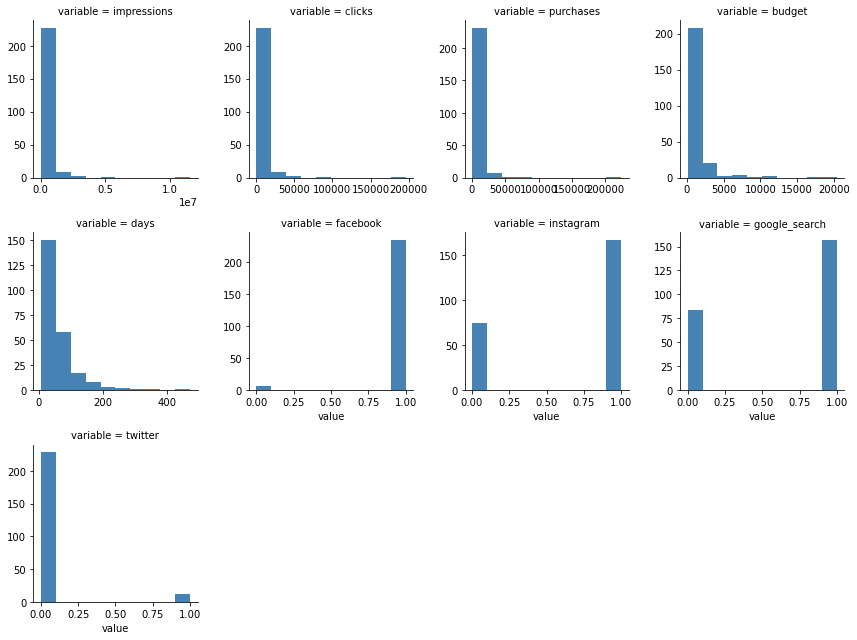

In [59]:
# Visualize distributions of numerical features with histograms
quan = list(data.loc[:, data.dtypes != 'object'].columns.values)
grid = sns.FacetGrid(pd.melt(data, value_vars=quan),
                     col='variable', col_wrap=4, height=3, aspect=1,
                     sharex=False, sharey=False)
grid.map(plt.hist, 'value', color="steelblue")
plt.show()

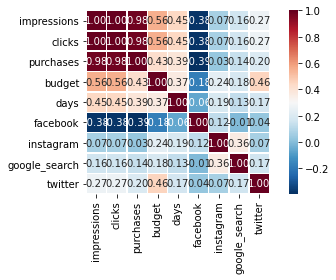

In [60]:
# Visualize feature correlations
sns.heatmap(data._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

In [61]:
# Investigate correlations between dependent and independent variables
data.corr(method='pearson').iloc[0].sort_values(ascending=False)

impressions      1.000000
clicks           1.000000
purchases        0.983326
budget           0.556317
days             0.449491
twitter          0.269616
google_search    0.164593
instagram        0.073916
facebook        -0.382057
Name: impressions, dtype: float64

In [62]:
# Investigate missing values
# Columns with NaN
data.isnull().sum()
# Rows with NaN
rows_with_nan = 0
for i in range(len(data)):
    rows_with_nan += data.iloc[i].isnull().sum()
print(rows_with_nan)

0


In [63]:
def mean_relative_accuracy(y_pred, y_true):
    """
    Helper function to calculate mean relative closeness of two vectors
    = 1 - mean percentage error
    """
    return 1 - np.mean(np.abs((y_pred - y_true) / y_true))


def powerlist(start, base, times):
    """
    Helper function to create lists with exponential outputs,
    e.g. for search grids
    """
    return [start * base ** i for i in range(0, times, 1)]

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def data_pipeline(data, output):
    """
    Preprocessing pipeline part 1: Transform full data frame
    Arguments: Pandas dataframe, output column (dependent variable)
    Returns: Modified dataframe
    """
    data = cost_per_metric(data, output) if 'cost_per' in output \
                                         else data[data[output] > 0]
    data = drop_columns(data, output, threshold=.5)
    data = data.dropna(axis='index')
    data = create_other_buckets(data, threshold=.1)
    data_cat = data
    data = one_hot_encode(data)
    return data, data_cat

def split_pipeline(data, output, encoded=True):
    """
    Preprocessing pipeline part 2: Split data into variables
    Arguments: Pandas dataframe, output column (dependent variable)
    Returns: List of scaled and unscaled dependent and independent variables
    """
    y, X = data.iloc[:, 0], data.iloc[:, 1:]
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop([output], axis=1), data[output], test_size=.2, random_state=1)
    if encoded:
        X_scaled, y_scaled, X_train_scaled, y_train_scaled, X_test_scaled, \
            y_scaler = scale(X, y, X_train, y_train, X_test)
        return [X, y, X_train, y_train, X_test, y_test, X_scaled, y_scaled,
                X_train_scaled, y_train_scaled, X_test_scaled, y_scaler]
    return [X, y, X_train, y_train, X_test, y_test]

def cost_per_metric(data, output):
    """Create 'cost_per_...' column and remove data where output is 0 or NaN"""
    metric = output.replace('cost_per_', '') + 's'
    data = data[data[metric] > 0]
    data.insert(0, output, [row['cost'] / row[metric]
                            for index, row in data.iterrows()])
    return data

def drop_columns(data, output, threshold=0.5):
    """Drop columns with more than threshold missing data"""
    rows = data[output].count()
    for column in list(data.columns):
        if data[column].count() < rows * threshold:
            data = data.drop([column], axis=1)
    return data

def create_other_buckets(data, threshold=0.1):
    """Put rare categorical values into other bucket"""
    categoricals = list(data.select_dtypes(include='object').columns)
    for column in categoricals:
        results = data[column].count()
        groups = data.groupby([column])[column].count()
        for bucket in groups.index:
            if groups.loc[bucket] < results * threshold:
                data.loc[data[column] == bucket, column] = 'other'
    return data

def one_hot_encode(data):
    """One-hot encode categorical data"""
    categoricals = list(data.select_dtypes(include='object').columns)
    for column in categoricals:
        if 'other' in data[column].unique():
            data = pd.get_dummies(data, columns=[column], prefix=[column],
                                  drop_first=False)
            data = data.drop([column + '_other'], axis=1)
        else:
            data = pd.get_dummies(data, columns=[column], prefix=[column],
                                  drop_first=True)
    return data

def scale(X, y, X_train, y_train, X_test):
    """Scale dependent and independent variables"""
    X_scaler, y_scaler = StandardScaler(), StandardScaler()

    X_scaled = X_scaler.fit_transform(X.values.astype(float))
    y_scaled = y_scaler.fit_transform(
        y.values.astype(float).reshape(-1, 1)).flatten()

    X_train_scaled = pd.DataFrame(data=X_scaler.transform(
        X_train.values.astype(float)), columns=X.columns)
    y_train_scaled = y_scaler.transform(
        y_train.values.astype(float).reshape(-1, 1)).flatten()

    X_test_scaled = pd.DataFrame(data=X_scaler.transform(
        X_test.values.astype(float)), columns=X.columns)

    return [X_scaled, y_scaled, X_train_scaled, y_train_scaled,
            X_test_scaled, y_scaler]

In [65]:
def train(output):    
    #ouput = 'impressions'

    data = pd.read_csv('campaigns.csv')
    print('Data loaded.')
    
    keep = output
    drop_candidates = ['impressions', 'clicks', 'purchases']
    drops = [drop for drop in drop_candidates if drop != keep and drop in data.columns]
    data = data.drop(drops, axis=1)

    data, data_cat = data_pipeline(data, output)
    [X, y, X_train, y_train, X_test, y_test, X_scaled, y_scaled,
    X_train_scaled, y_train_scaled, X_test_scaled, y_scaler] \
    = split_pipeline(data, output, encoded=True)
    [X_cat, y_cat, X_train_cat, y_train_cat, X_test_cat, y_test_cat] = \
    split_pipeline(data_cat, output, encoded=False)
    print('Data preprocessed.')

    scorer = make_scorer(mean_relative_accuracy)
    
    forest_parameters = [{'n_estimators': powerlist(10, 2, 4),
                           'min_samples_leaf': list(range(2, 10, 1)),
                           'criterion': ['mae', 'mse'],
                           'random_state': [1], 'n_jobs': [-1]}]
    forest_search = GridSearchCV(estimator=RandomForestRegressor(),
                                  param_grid=forest_parameters,
                                  scoring=scorer, cv=5, n_jobs=-1,
                                  iid=False)
    forest_search_result = forest_search.fit(X_train, y_train)
    best_forest_parameters = dict(forest_search_result.best_params_)
    forest_score = forest_search_result.best_score_
    print('Best forest params: ' + str(best_forest_parameters))
    print('Forest score: ' + str(forest_score))
    regression = RandomForestRegressor(
                n_estimators=best_forest_parameters['n_estimators'],
                min_samples_leaf=best_forest_parameters['min_samples_leaf'],
                criterion=best_forest_parameters['criterion'],
                random_state=1, n_jobs=-1)
    regression.fit(X, y)
    joblib.dump(regression, output + '_model.pkl')
    joblib.dump(X, output + '_train.pkl')
    joblib.dump(y, output + '_actuals.pkl')
    print('Regressor fit.')

In [66]:
train('impressions')

Data loaded.
Data preprocessed.


C:\Users\reddy\anaconda3\envs\v-env\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best forest params: {'criterion': 'mse', 'min_samples_leaf': 3, 'n_estimators': 40, 'n_jobs': -1, 'random_state': 1}
Forest score: 0.7096962679164467
Regressor fit.


In [67]:
train('purchases')

Data loaded.
Data preprocessed.


C:\Users\reddy\anaconda3\envs\v-env\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best forest params: {'criterion': 'mse', 'min_samples_leaf': 6, 'n_estimators': 40, 'n_jobs': -1, 'random_state': 1}
Forest score: 0.6767508694481563
Regressor fit.


In [68]:
budget=15000
days=30
fb=1
insta=1
search=1 
twitter=1
data = {'budget': [budget], 'days': [days], 'fb': [fb], 'insta':[insta], 'search':[search], 'twitter':[twitter]}
df = pd.DataFrame(data, columns = ['budget','days','fb','insta','search','twitter'])
df

,budget,days,fb,insta,search,twitter
0,15000,30,1,1,1,1


In [69]:
def predict(data, output):
    if output == 'impressions':
        regression = joblib.load('impressions_model.pkl')
        X = data
        y = joblib.load('impressions_actuals.pkl')
        predictions = regression.predict(X).astype(int)
        return predictions
    else:
        regression = joblib.load('purchases_model.pkl')
        X = data
        y = joblib.load('purchases_actuals.pkl')
        predictions = regression.predict(X).astype(int)
        return predictions

In [70]:
p=predict(df,'impressions')

In [71]:
p1=predict(df,'purchases')

In [72]:
impressions

array([2721871])

In [73]:
purchases

array([26827])